# Import and Read Data

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import sys 
import os
import time
from copy import deepcopy
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import model_selection
from sklearn.metrics.pairwise import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
original_data = pd.read_csv('/content/drive/MyDrive/FairML/US/Data/original_data.csv',dtype=object)

In [ ]:
original_no_overdose_data = pd.read_csv('/content/drive/MyDrive/FairML/US/Data/original_no_overdose_data.csv',dtype=object)

In [ ]:
original_overdose_data = pd.read_csv('/content/drive/MyDrive/FairML/US/Data/original_overdose_data.csv',dtype=object)

In [ ]:
category_features = [x for x in original_data.columns if original_data[x].dtype != float]
category_features

['General_Record_Type',
 'General_Resident_status',
 'General_Place_of_death_and_decedents_status',
 'General_Day_of_week_of_death',
 'General_Data_year',
 'General_Manner_of_death',
 'Occurrence_State(FIPS)',
 'Occurrence_County(FIPS)',
 'Occurrence_County_Population_size',
 'Residence_State(FIPS)',
 'Residence_County(FIPS)',
 'Residence_Met_or_Nonmet_county',
 'The_Decedent_Date_of_Death',
 'The_Decedent_Sex',
 'The_Decedent_Age',
 'The_Decedent_Marital_status',
 'The_Decedent_State_or_country_of_birth',
 'The_Decedent_Education',
 'Underlying_Cause_ICD-10_code',
 'The_Decedent_Race_Recode_5',
 'The_Decedent_Hispanic_Origin/Race_Recode',
 'The_Decedent_Race']

In [ ]:
original_data["General_Data_year"].value_counts()

2019    2833007
2018    2817121
2017    2789825
2016    2718635
2015    2686900
2014    2600327
2013    2570146
2012    2516220
2011    2487774
2010    2439904
Name: General_Data_year, dtype: int64

In [ ]:
len(original_data["General_Data_year"])

26459859

In [ ]:
len(original_overdose_data["General_Data_year"])

537993

# Plot Rate by years

In [ ]:
original_data["Occurrence_State(FIPS)"].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [ ]:
years = np.array([x for x in range(2010,2020)])
years = years.astype(str)

In [ ]:
states = original_data["Occurrence_State(FIPS)"].unique()
states = states.astype(str)

In [ ]:
years

array(['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019'], dtype='<U21')

In [ ]:
states

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype='<U2')

In [ ]:
original_overdose_data[(original_overdose_data["Occurrence_State(FIPS)"] == "AK" )]

In [ ]:
numofdeathinyearsandstates=[]
numofODdeathinyearsandstates=[]
for i in states:
  tmp1=[]
  tmp2=[]
  print(i)
  tmpall=original_data[(original_data["Occurrence_State(FIPS)"] == i )]
  tmpOD=original_overdose_data[(original_overdose_data["Occurrence_State(FIPS)"] == i )]
  for j in years:
    tmp1.append(len(tmpall[(tmpall["General_Data_year"] == j )]))
    tmp2.append(len(tmpOD[(tmpOD["General_Data_year"] == j )]))
  print(tmp1)
  print(tmp2)
  numofdeathinyearsandstates.append(tmp1)
  numofODdeathinyearsandstates.append(tmp2)

In [ ]:
print(numofdeathinyearsandstates)

[[3571, 3691, 3741, 3820, 3925, 4092, 4271, 4190, 4248, 4456], [46664, 47221, 47748, 48642, 48643, 50236, 50757, 51718, 52736, 52574], [28202, 28791, 29221, 29707, 29557, 30617, 30637, 31447, 31449, 31988], [46876, 48499, 49538, 50589, 51440, 54214, 56578, 57694, 59511, 60488], [231240, 237552, 240156, 245749, 243840, 257269, 260291, 266619, 267424, 268319], [31313, 32531, 33126, 33730, 35287, 36531, 37672, 38310, 38686, 39665], [28574, 29378, 29110, 29496, 29678, 30362, 30428, 31326, 31254, 31742], [5525, 5372, 5207, 5382, 5270, 5468, 5831, 6008, 5989, 5855], [7555, 7761, 7778, 7849, 8172, 8464, 8858, 9020, 9371, 9155], [173173, 173651, 176927, 181085, 186064, 192358, 198020, 204285, 206287, 207929], [70576, 70583, 72369, 74524, 76278, 79218, 80532, 82446, 84592, 84992], [9516, 9833, 10243, 10410, 10770, 11074, 10895, 11383, 11399, 11615], [27482, 27834, 27955, 28517, 28685, 29075, 29030, 30015, 29957, 30437], [11159, 11702, 11751, 12198, 12361, 12868, 13127, 13776, 14052, 14191], [95

In [ ]:
print(numofODdeathinyearsandstates)

[[76, 103, 125, 106, 123, 120, 129, 141, 105, 132], [531, 546, 558, 587, 705, 717, 738, 807, 735, 739], [350, 340, 364, 315, 351, 381, 383, 421, 431, 358], [1093, 1073, 1142, 1241, 1234, 1265, 1390, 1552, 1728, 1976], [4081, 4238, 4074, 4491, 4576, 4751, 4746, 5016, 5486, 6353], [679, 866, 831, 857, 916, 912, 961, 1040, 1004, 1095], [353, 395, 427, 570, 627, 795, 969, 1078, 1070, 1231], [87, 99, 90, 116, 117, 144, 300, 348, 295, 366], [143, 156, 135, 161, 192, 193, 285, 340, 398, 422], [3158, 2958, 2617, 2478, 2684, 3345, 4990, 5437, 4933, 5513], [1056, 1049, 1054, 1079, 1201, 1303, 1364, 1513, 1372, 1371], [154, 182, 152, 155, 162, 171, 199, 201, 212, 244], [246, 247, 259, 272, 274, 299, 313, 341, 276, 348], [177, 186, 177, 201, 199, 212, 227, 233, 243, 262], [1290, 1413, 1589, 1581, 1671, 1862, 2425, 2762, 2728, 2774], [911, 965, 1002, 1066, 1152, 1229, 1504, 1832, 1606, 1702], [258, 278, 321, 324, 322, 323, 313, 323, 341, 378], [966, 1030, 1072, 1011, 1085, 1245, 1435, 1566, 1336, 1

In [ ]:
ODrateinyearsandstates=np.divide(numofODdeathinyearsandstates,numofdeathinyearsandstates)

In [ ]:
print(ODrateinyearsandstates)

In [ ]:
i=0
for row in ODrateinyearsandstates:
  plt.figure(figsize=(9,3))
  plt.plot(years,row)
  plt.xlabel("year")
  plt.ylabel("ODrate in state {}".format(states[i]))
  i=i+1
  plt.show()

In [ ]:
numofdeathinyears=[]
numofODdeathinyears=[]
for i in years:
  print(i)
  numofdeathinyears.append(len(original_data[(original_data["General_Data_year"] == i )]))
  numofODdeathinyears.append(len(original_overdose_data[(original_overdose_data["General_Data_year"] == i )]))

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [ ]:
ODrateinyears=np.divide(numofODdeathinyears,numofdeathinyears)
ODrateinyears

array([0.01570185, 0.01663133, 0.01650611, 0.01712821, 0.01811618,
       0.01954036, 0.02347428, 0.02530159, 0.02404902, 0.02505712])

<function matplotlib.pyplot.show(*args, **kw)>

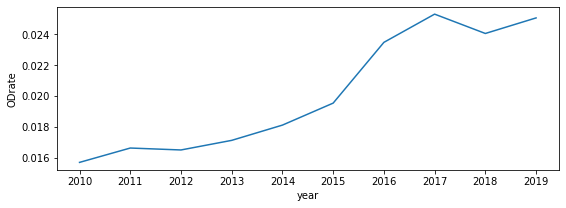

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(years,ODrateinyears)
plt.xlabel("year")
plt.ylabel("General ODrate")
plt.show

The Pearson correlation coefficient is: 0.946869539090634. The P-value is: 3.2688157574016595e-05.


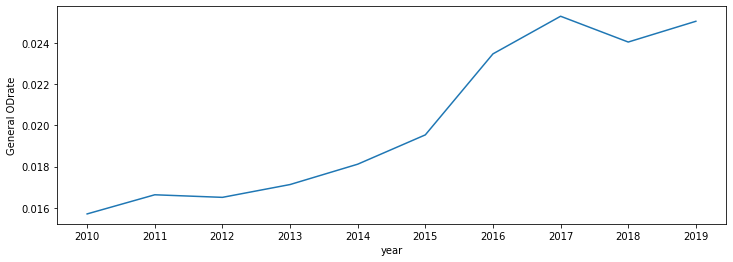

In General: The Pearson correlation coefficient is: 0.946869539090634. The P-value is: 3.2688157574016595e-05.


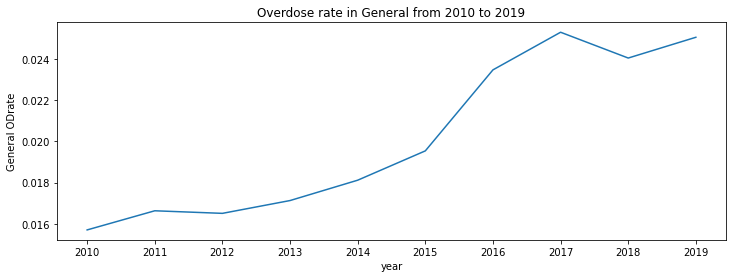

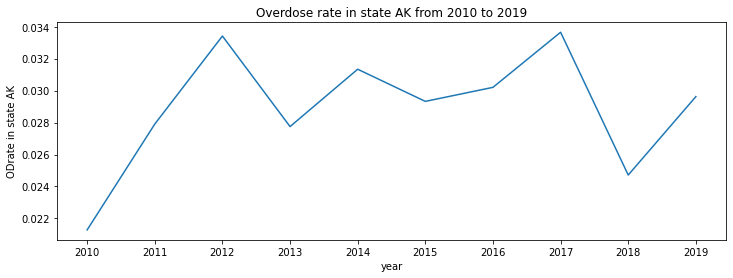

In state AK: The Pearson correlation coefficient is: 0.2872231773981126. The P-value is: 0.4210170678022872.


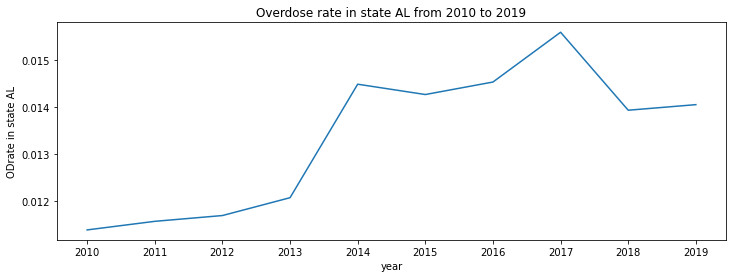

In state AL: The Pearson correlation coefficient is: 0.8110890799026722. The P-value is: 0.00440555906878163.


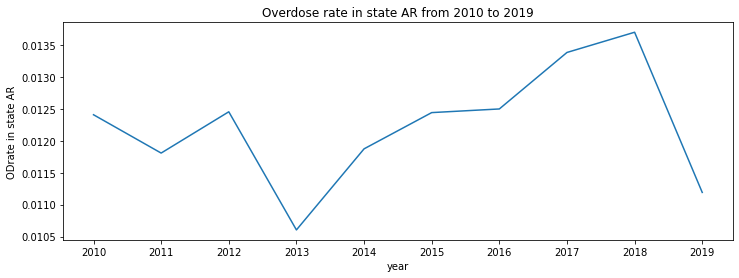

In state AR: The Pearson correlation coefficient is: 0.2614215423356362. The P-value is: 0.46564550799890175.


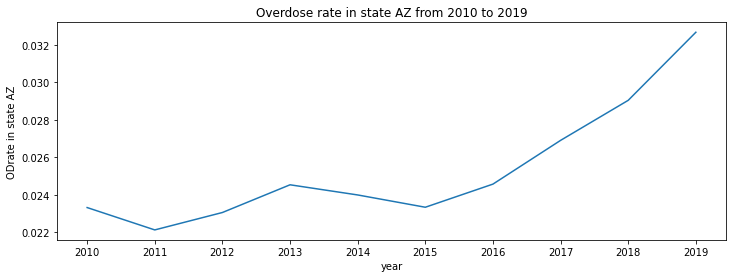

In state AZ: The Pearson correlation coefficient is: 0.847231836101056. The P-value is: 0.0019732785425619027.


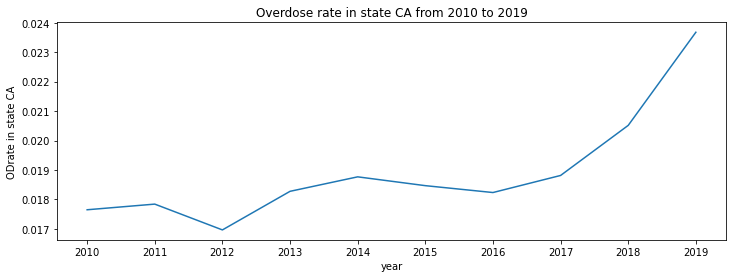

In state CA: The Pearson correlation coefficient is: 0.7849550866955894. The P-value is: 0.007151407589390445.


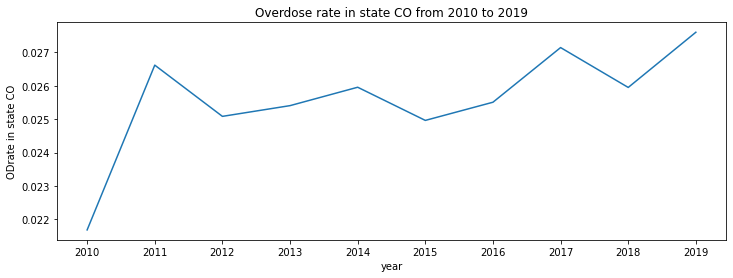

In state CO: The Pearson correlation coefficient is: 0.6577184190080831. The P-value is: 0.038730741139071496.


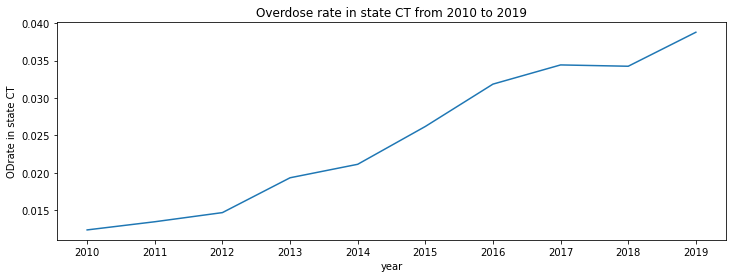

In state CT: The Pearson correlation coefficient is: 0.986023028531618. The P-value is: 1.6418274194886107e-07.


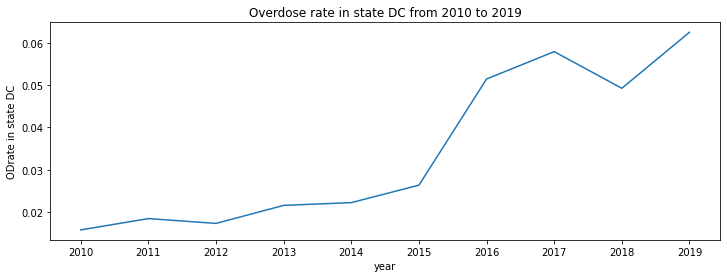

In state DC: The Pearson correlation coefficient is: 0.918751334963791. The P-value is: 0.00017268635852010569.


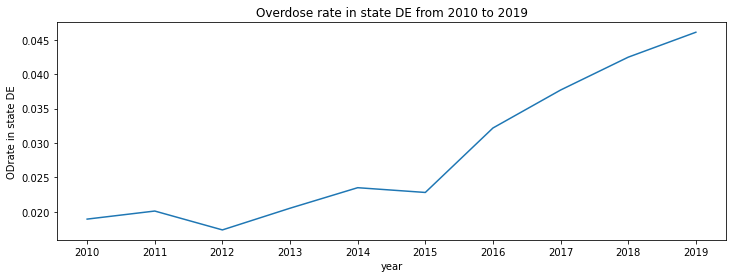

In state DE: The Pearson correlation coefficient is: 0.9305986908385955. The P-value is: 9.328521333818985e-05.


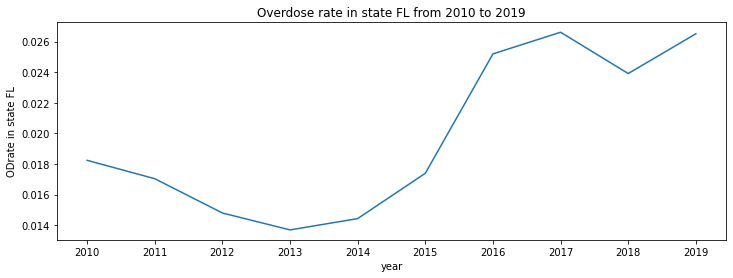

In state FL: The Pearson correlation coefficient is: 0.7713909003674075. The P-value is: 0.008973487186194515.


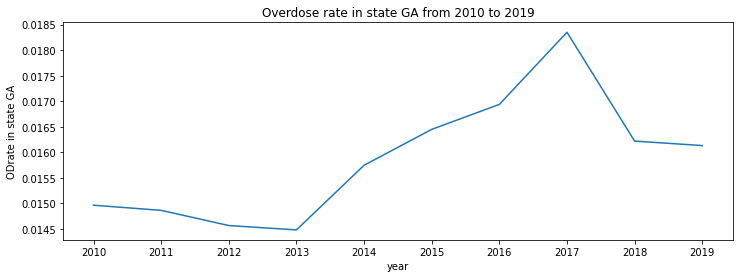

In state GA: The Pearson correlation coefficient is: 0.7094337539709643. The P-value is: 0.021573883521451565.


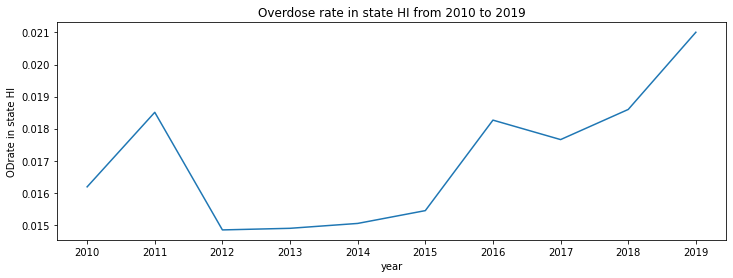

In state HI: The Pearson correlation coefficient is: 0.6055433904306294. The P-value is: 0.06355856594207963.


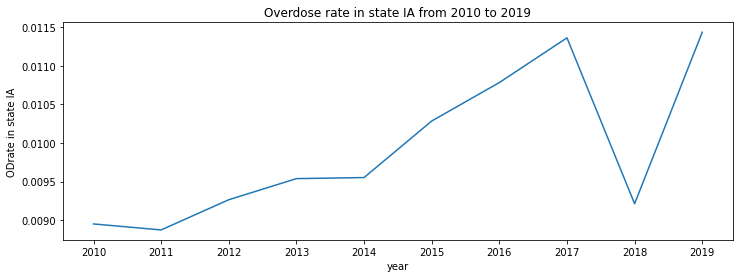

In state IA: The Pearson correlation coefficient is: 0.7494714767930786. The P-value is: 0.012574953981530492.


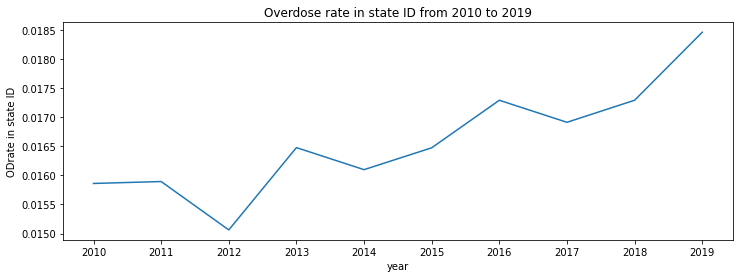

In state ID: The Pearson correlation coefficient is: 0.8696046867011009. The P-value is: 0.0010774538114956603.


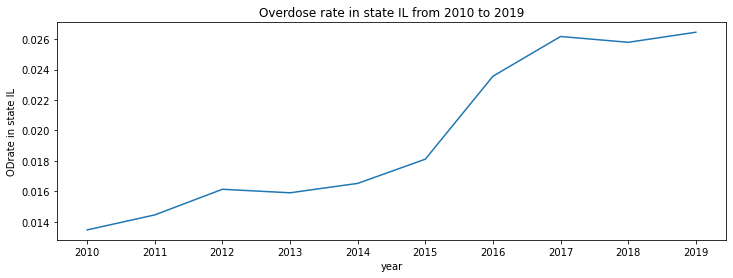

In state IL: The Pearson correlation coefficient is: 0.9518532531698058. The P-value is: 2.2178399725163705e-05.


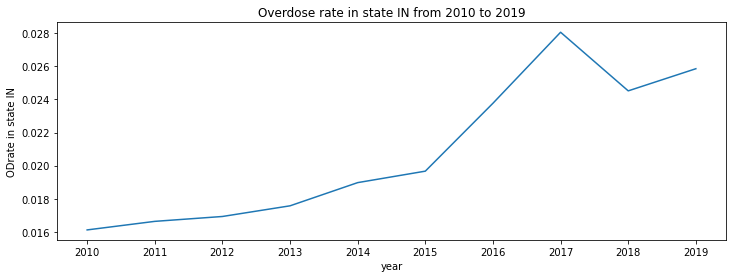

In state IN: The Pearson correlation coefficient is: 0.9188899013050094. The P-value is: 0.00017154072308612304.


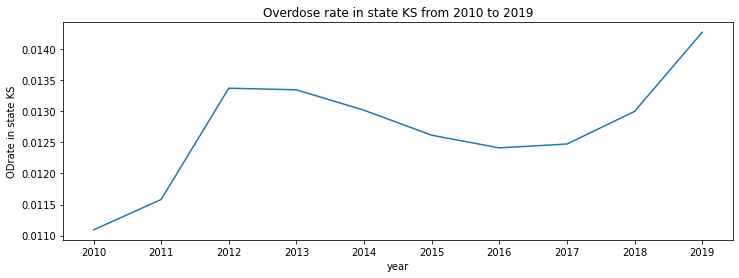

In state KS: The Pearson correlation coefficient is: 0.6198410796636031. The P-value is: 0.055936250861244895.


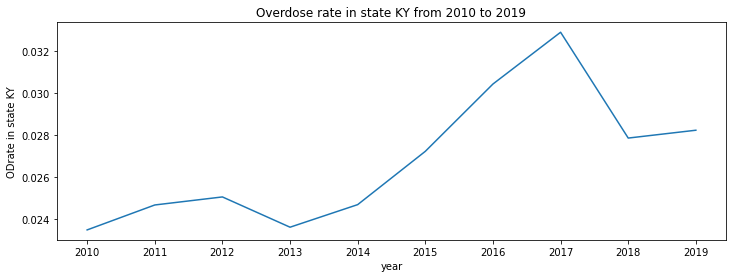

In state KY: The Pearson correlation coefficient is: 0.7513504436053983. The P-value is: 0.012232211907804652.


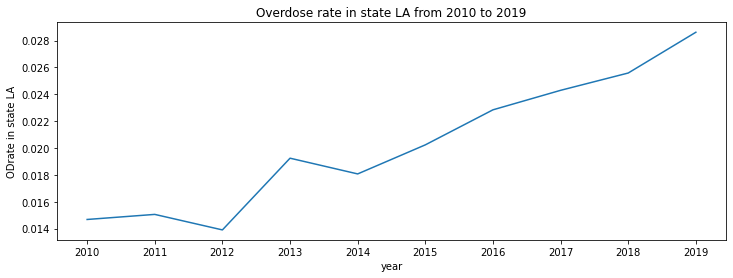

In state LA: The Pearson correlation coefficient is: 0.9677587956904479. The P-value is: 4.546952890013371e-06.


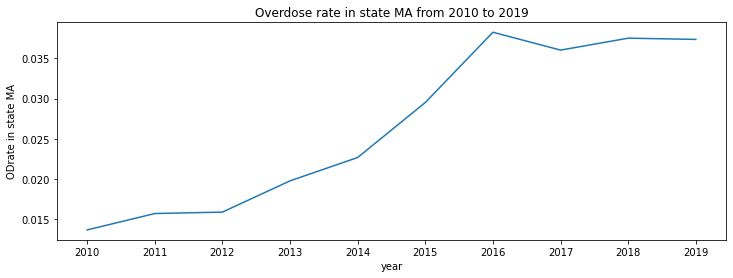

In state MA: The Pearson correlation coefficient is: 0.9542770989611034. The P-value is: 1.8091842307808507e-05.


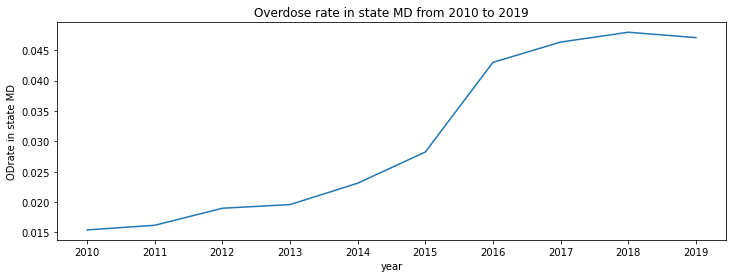

In state MD: The Pearson correlation coefficient is: 0.9521023569582249. The P-value is: 2.1729569860808418e-05.


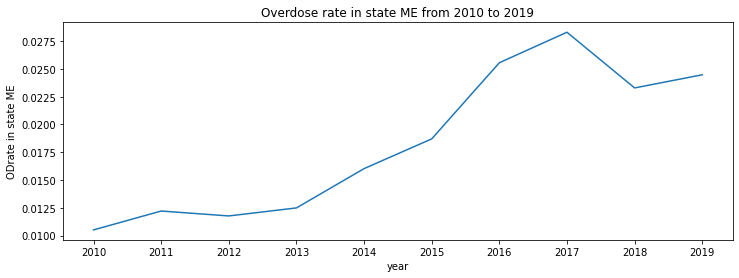

In state ME: The Pearson correlation coefficient is: 0.9075935946190712. The P-value is: 0.00028496797589368494.


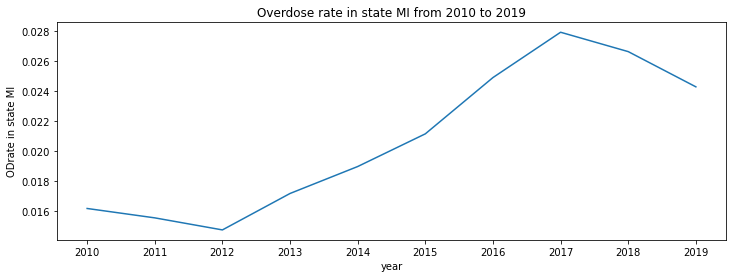

In state MI: The Pearson correlation coefficient is: 0.9058803612887385. The P-value is: 0.0003060443910455051.


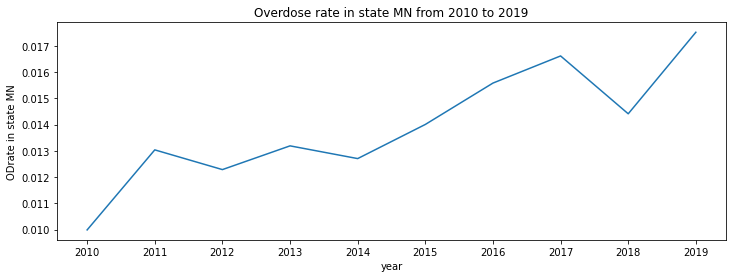

In state MN: The Pearson correlation coefficient is: 0.8908491920072912. The P-value is: 0.00054329524142836.


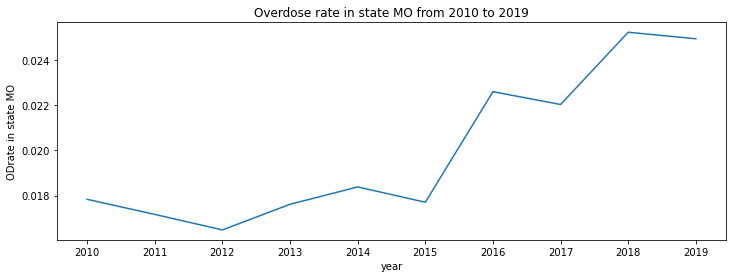

In state MO: The Pearson correlation coefficient is: 0.8883170879947996. The P-value is: 0.0005936083414520841.


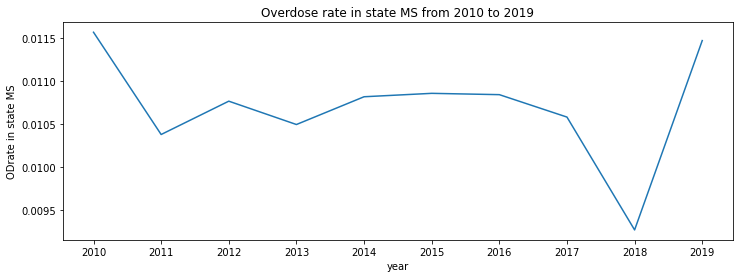

In state MS: The Pearson correlation coefficient is: -0.24553286175525751. The P-value is: 0.4941224397004083.


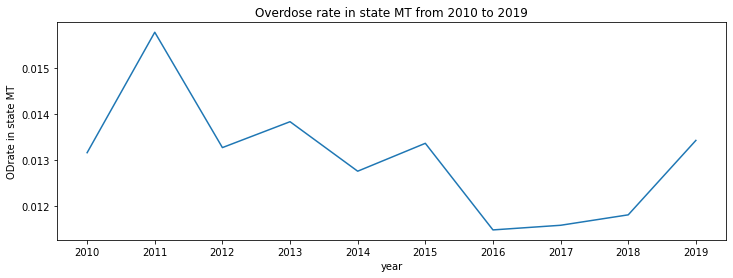

In state MT: The Pearson correlation coefficient is: -0.5802750291803241. The P-value is: 0.07863494051865698.


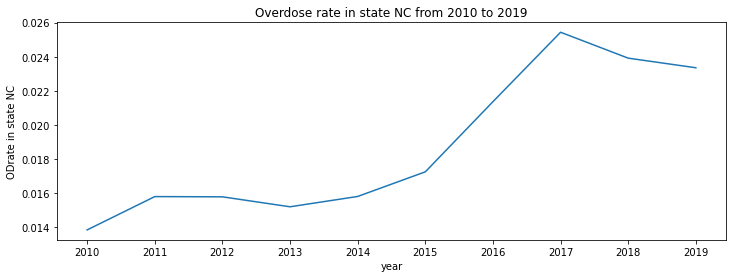

In state NC: The Pearson correlation coefficient is: 0.9039013980517376. The P-value is: 0.0003317899704869856.


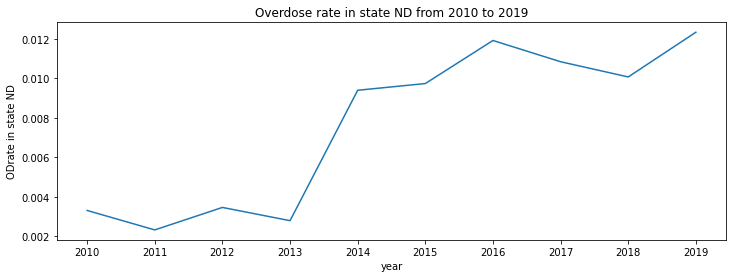

In state ND: The Pearson correlation coefficient is: 0.8935053714025522. The P-value is: 0.000493946440754098.


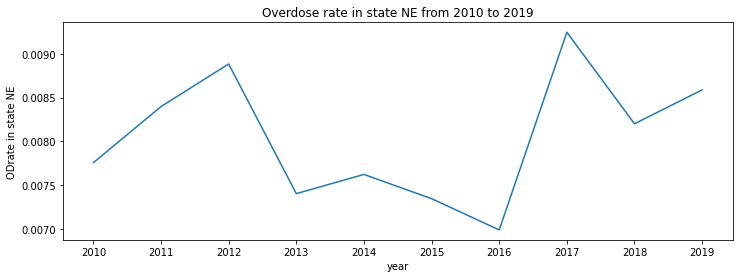

In state NE: The Pearson correlation coefficient is: 0.15950882335616834. The P-value is: 0.659817479212351.


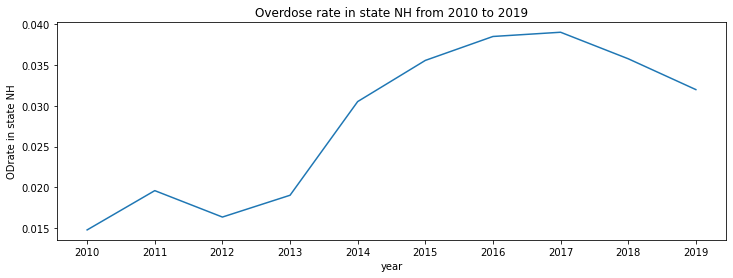

In state NH: The Pearson correlation coefficient is: 0.8485230057881716. The P-value is: 0.0019105395064561953.


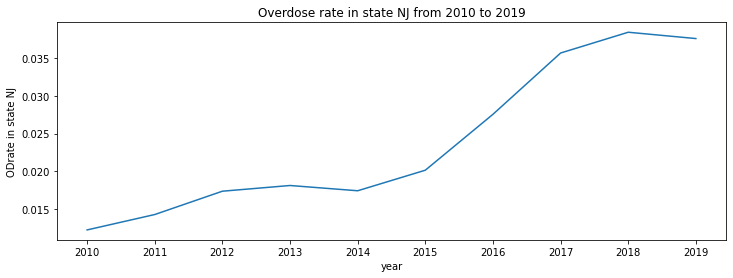

In state NJ: The Pearson correlation coefficient is: 0.9479378867540929. The P-value is: 3.0176646451616867e-05.


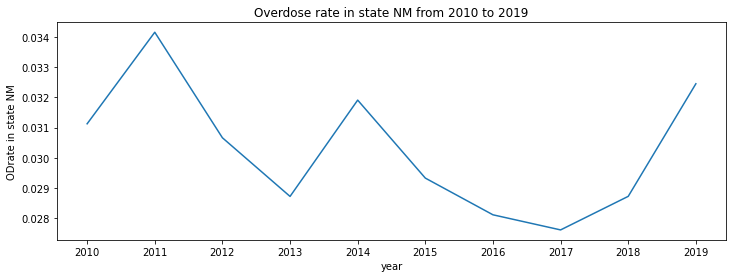

In state NM: The Pearson correlation coefficient is: -0.39426453538629397. The P-value is: 0.25956911701787977.


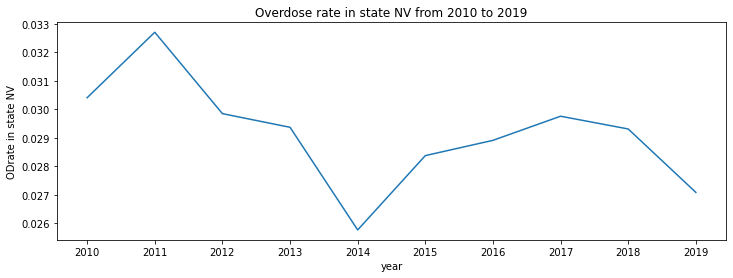

In state NV: The Pearson correlation coefficient is: -0.5186093389467763. The P-value is: 0.12457593250619389.


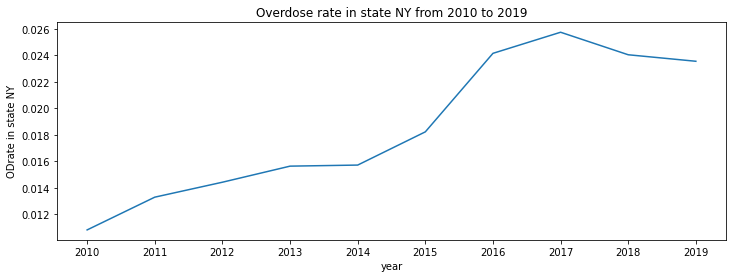

In state NY: The Pearson correlation coefficient is: 0.9382622426104199. The P-value is: 5.897087027375384e-05.


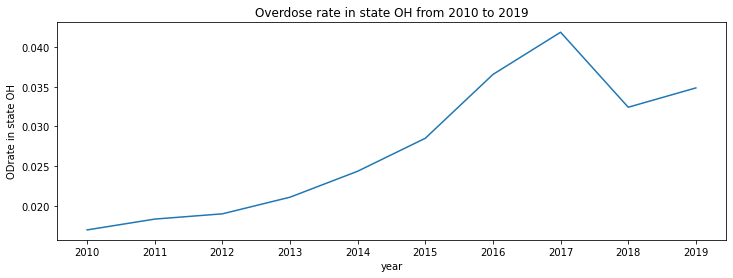

In state OH: The Pearson correlation coefficient is: 0.8922940495753617. The P-value is: 0.0005160251626465256.


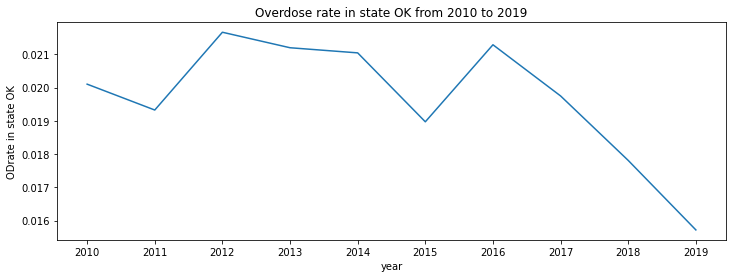

In state OK: The Pearson correlation coefficient is: -0.6106179433764858. The P-value is: 0.060779714186950315.


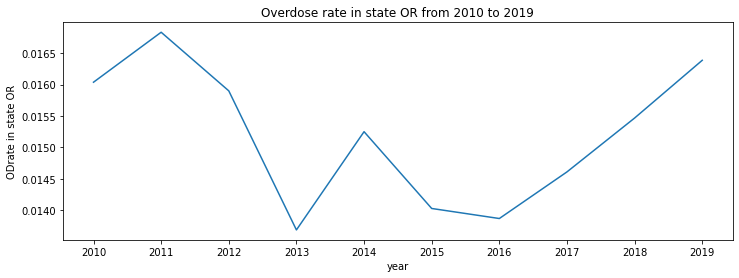

In state OR: The Pearson correlation coefficient is: -0.22357574476621836. The P-value is: 0.5346503896518935.


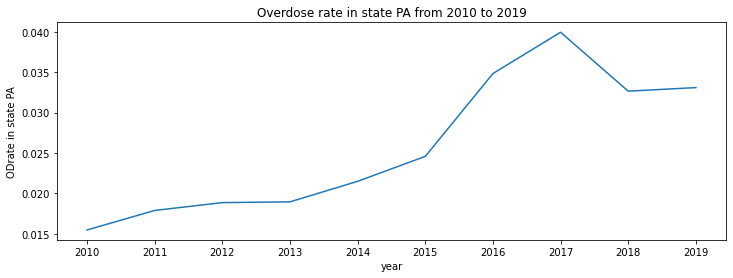

In state PA: The Pearson correlation coefficient is: 0.8916803322159825. The P-value is: 0.0005274829232549721.


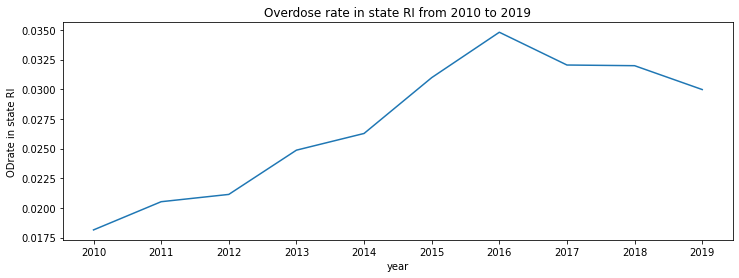

In state RI: The Pearson correlation coefficient is: 0.8828305126966494. The P-value is: 0.0007142122754145185.


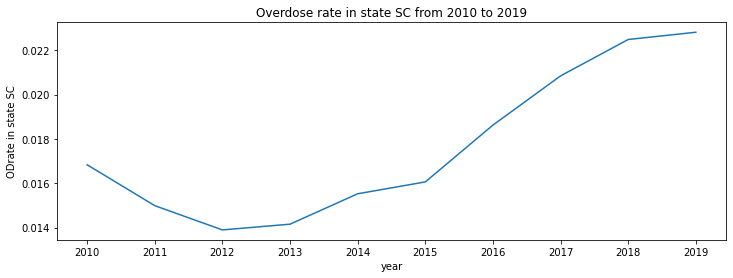

In state SC: The Pearson correlation coefficient is: 0.8435264173001765. The P-value is: 0.0021615973324984146.


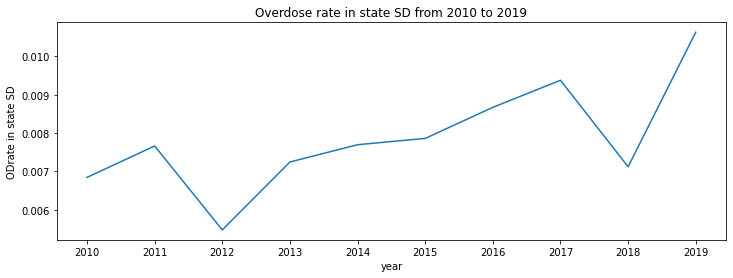

In state SD: The Pearson correlation coefficient is: 0.6970024299543576. The P-value is: 0.025086940426060855.


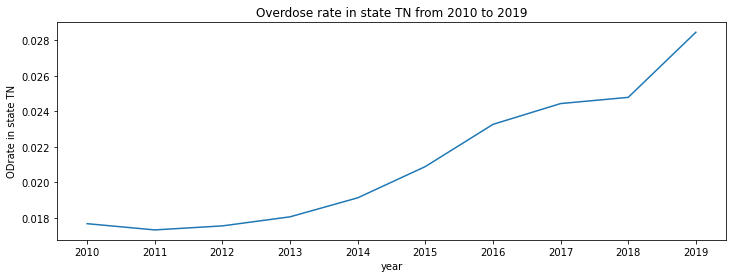

In state TN: The Pearson correlation coefficient is: 0.9518224303632312. The P-value is: 2.2234410206603885e-05.


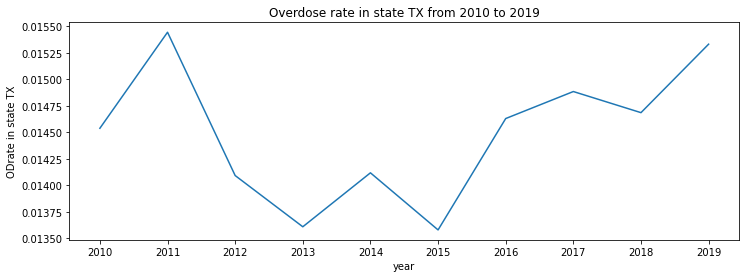

In state TX: The Pearson correlation coefficient is: 0.23683146284917025. The P-value is: 0.510024366105551.


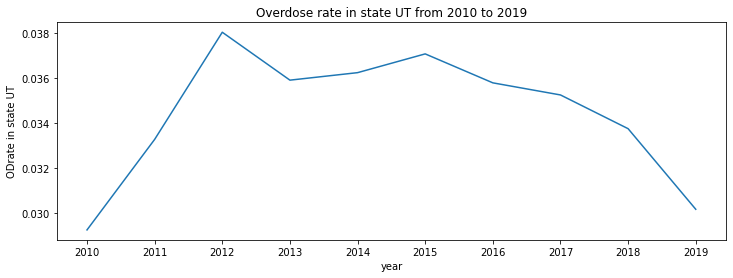

In state UT: The Pearson correlation coefficient is: -0.011876046458093842. The P-value is: 0.9740248121325512.


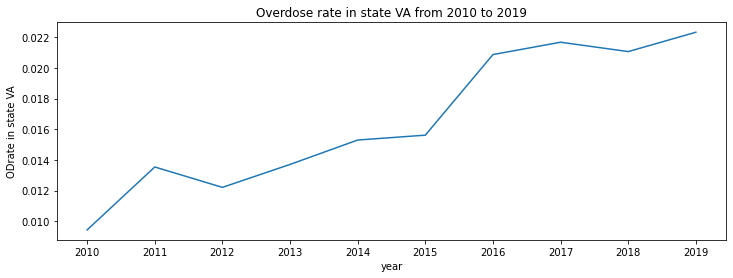

In state VA: The Pearson correlation coefficient is: 0.9555524441981997. The P-value is: 1.6181359914068102e-05.


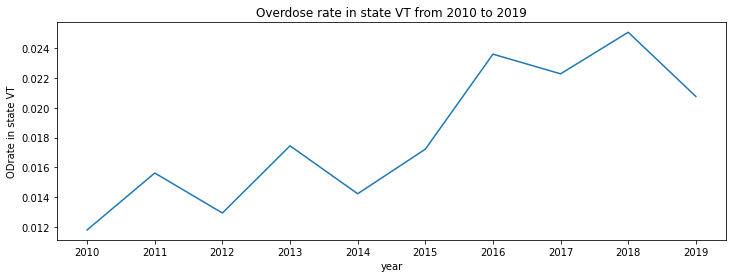

In state VT: The Pearson correlation coefficient is: 0.8537697937413822. The P-value is: 0.0016703549301516254.


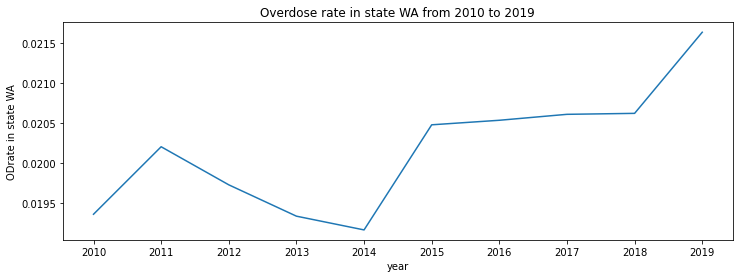

In state WA: The Pearson correlation coefficient is: 0.7799877070144295. The P-value is: 0.00778488184504049.


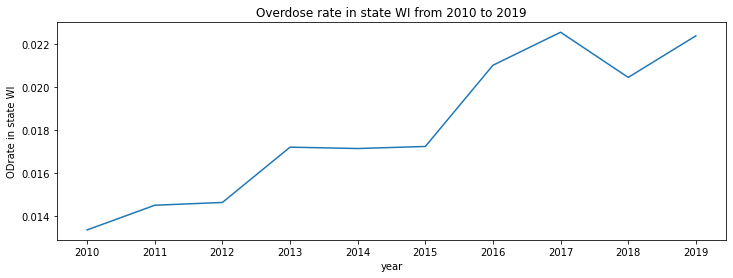

In state WI: The Pearson correlation coefficient is: 0.9479954544332911. The P-value is: 3.0045512146896704e-05.


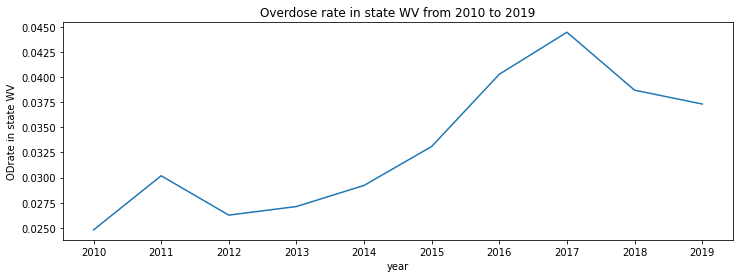

In state WV: The Pearson correlation coefficient is: 0.839070489026796. The P-value is: 0.002404854916499591.


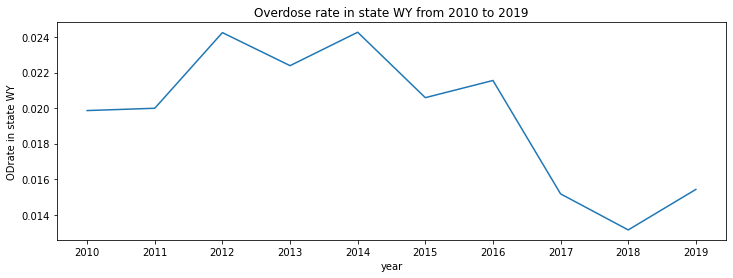

In state WY: The Pearson correlation coefficient is: -0.660873993352095. The P-value is: 0.03748354971264766.


In [ ]:
from scipy.stats import pearsonr
plt.figure(figsize=(12,4))
plt.plot(years,ODrateinyears)
plt.xlabel("year")
plt.ylabel("General ODrate")
plt.title("Overdose rate in General from 2010 to 2019")
plt.show

correlation, p_value = pearsonr(range(2010,2020), ODrateinyears)
print('In General: The Pearson correlation coefficient is: {}. The P-value is: {}.'.format(correlation, p_value))
i=0
for row in ODrateinyearsandstates:
  plt.figure(figsize=(12,4))
  plt.plot(years,row)
  plt.xlabel("year")
  plt.ylabel("ODrate in state {}".format(states[i]))
  plt.title("Overdose rate in state {} from 2010 to 2019".format(states[i]))
  plt.show()
  correlation, p_value = pearsonr(range(2010,2020), row)
  print('In state {}: The Pearson correlation coefficient is: {}. The P-value is: {}.'.format(states[i],correlation, p_value))
  i=i+1

# Plot
#Death rate of years
(to estimate the death rate in the future. Of course we should consider the death rate by state, county, race, ubran/rural, year, maybe sex)
#What does the accident contain
(accroding my calculation, 30% people who die for accident was die for fatal overdose)


In [ ]:
original_overdose_data['Underlying_Cause_ICD-10_code'].count()

537993

In [ ]:
print(original_data['Underlying_Cause_ICD-10_code'].value_counts())

I251    1650686
C349    1499144
I219    1111602
J449    1108896
F03     1092508
         ...   
L678          1
N926          1
D199          1
A920          1
O051          1
Name: Underlying_Cause_ICD-10_code, Length: 5200, dtype: int64


In [ ]:
original_data['General_Manner_of_death'].unique()

array(['7', '2', '1', '3', '4', '5', ' '], dtype=object)

In [ ]:
allaccidentrow = original_data[original_data['General_Manner_of_death'] == '1']

In [ ]:
allaccidentrow['General_Manner_of_death'].unique()

array(['1'], dtype=object)

In [ ]:
allaccidentrow['Underlying_Cause_ICD-10_code'].count()

1401494

In [ ]:
print(allaccidentrow['Underlying_Cause_ICD-10_code'].value_counts())

In [ ]:
value_countsofallaccidentrow = allaccidentrow['Underlying_Cause_ICD-10_code'].value_counts()
value_countsofallaccidentrowhead=value_countsofallaccidentrow.head(20)
x = value_countsofallaccidentrowhead.index
y = value_countsofallaccidentrowhead.values

In [ ]:
value_countsofallaccidentrowhead

X42     203442
X44     195821
W19     134446
V892    107713
W18     105894
V877     40670
X41      39498
V092     30917
W10      22716
I250     21337
V031     19840
X00      19485
X45      15963
W69      15106
V435     14023
W79      11413
V475     11204
V299     10816
X599     10079
V499      9865
Name: Underlying_Cause_ICD-10_code, dtype: int64

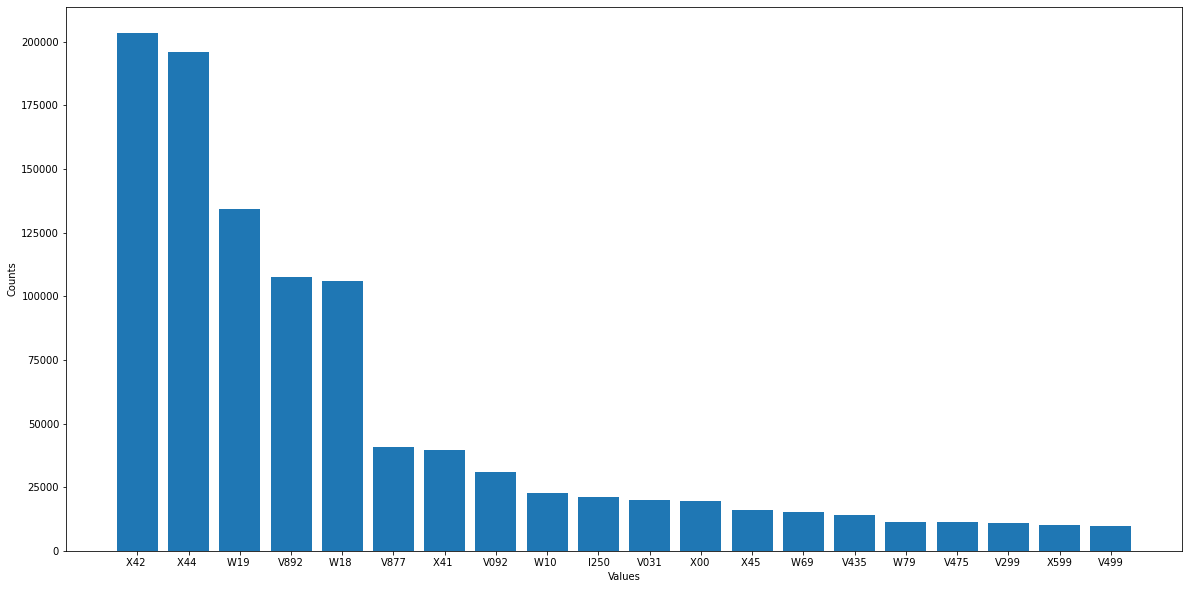

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(x, y)
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()

In [ ]:
allaccidentrow['Underlying_Cause_ICD-10_code'].value_counts()

203442

# Check Value of DataFrame

In [ ]:
original_data['General_Manner_of_death'].value_counts()

7    20721681
      3593583
1     1401494
2      436946
3      178446
5       90984
4       36725
Name: General_Manner_of_death, dtype: int64

1    21451148
2     5008711
Name: General_Record_Type, dtype: int64


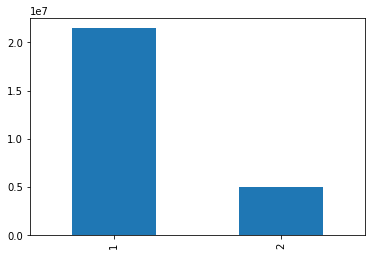

In [ ]:
original_data['General_Record_Type'].value_counts().plot(kind='bar')
print(original_data['General_Record_Type'].value_counts())

In [ ]:
original_overdose_data['General_Record_Type'].value_counts().plot(kind='bar')
print(original_overdose_data['General_Record_Type'].value_counts())

In [ ]:
original_data['General_Resident_status'].value_counts().plot(kind='bar')
print(original_data['General_Resident_status'].value_counts())

1    453098
2     60815
3     21554
4      2526
Name: General_Resident_status, dtype: int64


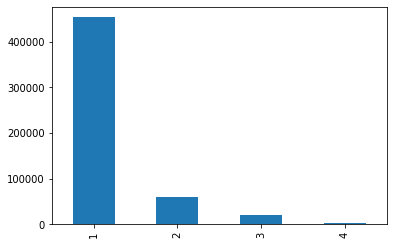

In [ ]:
original_overdose_data['General_Resident_status'].value_counts().plot(kind='bar')
print(original_overdose_data['General_Resident_status'].value_counts())

1    7886032
4    7885640
6    5294377
5    1839120
2    1709978
7    1708297
3     123879
9      12536
Name: General_Place_of_death_and_decedents_status, dtype: int64


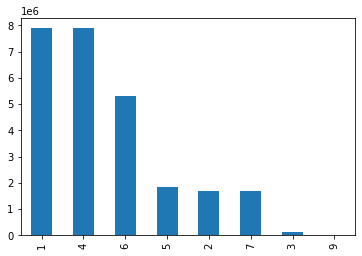

In [ ]:
original_data['General_Place_of_death_and_decedents_status'].value_counts().plot(kind='bar')
print(original_data['General_Place_of_death_and_decedents_status'].value_counts())

4    280767
7    110800
2     75242
1     57919
3      9656
5      1834
6      1351
9       424
Name: General_Place_of_death_and_decedents_status, dtype: int64


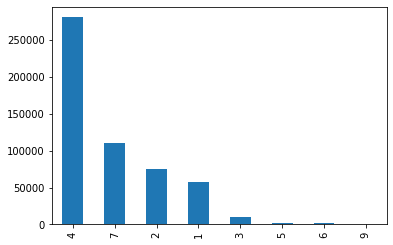

In [ ]:
original_overdose_data['General_Place_of_death_and_decedents_status'].value_counts().plot(kind='bar')
print(original_overdose_data['General_Place_of_death_and_decedents_status'].value_counts())

6    3822966
7    3816389
2    3786188
5    3763589
3    3758014
4    3756439
1    3754779
9       1495
Name: General_Day_of_week_of_death, dtype: int64


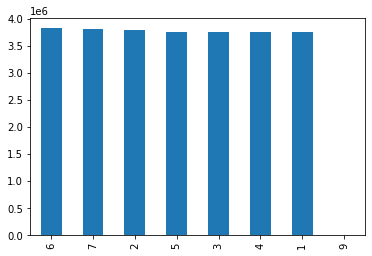

In [ ]:
original_data['General_Day_of_week_of_death'].value_counts().plot(kind='bar')
print(original_data['General_Day_of_week_of_death'].value_counts())

7    86744
1    80198
6    79472
5    74207
2    73203
4    72532
3    71440
9      197
Name: General_Day_of_week_of_death, dtype: int64


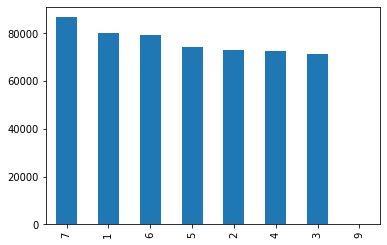

In [ ]:
original_overdose_data['General_Day_of_week_of_death'].value_counts().plot(kind='bar')
print(original_overdose_data['General_Day_of_week_of_death'].value_counts())

2019    2833007
2018    2817121
2017    2789825
2016    2718635
2015    2686900
2014    2600327
2013    2570146
2012    2516220
2011    2487774
2010    2439904
Name: General_Data_year, dtype: int64


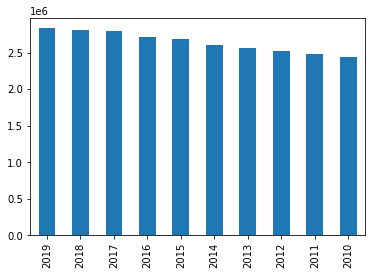

In [ ]:
original_data['General_Data_year'].value_counts().plot(kind='bar')
print(original_data['General_Data_year'].value_counts())

2019    70987
2017    70587
2018    67749
2016    63818
2015    52503
2014    47108
2013    44022
2012    41533
2011    41375
2010    38311
Name: General_Data_year, dtype: int64


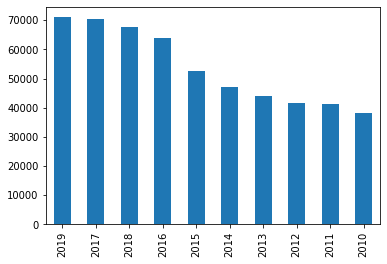

In [ ]:
original_overdose_data['General_Data_year'].value_counts().plot(kind='bar')
print(original_overdose_data['General_Data_year'].value_counts())

7    20721681
      3593583
1     1401494
2      436946
3      178446
5       90984
4       36725
Name: General_Manner_of_death, dtype: int64


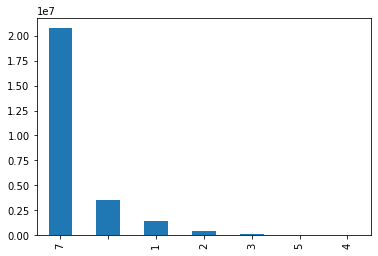

In [ ]:
original_data['General_Manner_of_death'].value_counts().plot(kind='bar')
print(original_data['General_Manner_of_death'].value_counts())

1    440820
2     52287
5     31451
7      9846
       1685
4      1131
3       773
Name: General_Manner_of_death, dtype: int64


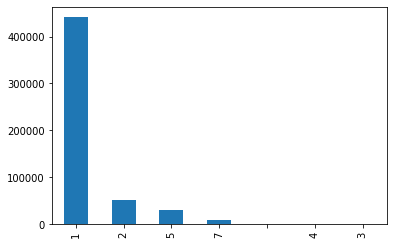

In [ ]:
original_overdose_data['General_Manner_of_death'].value_counts().plot(kind='bar')
print(original_overdose_data['General_Manner_of_death'].value_counts())

CA    2518459
FL    1899779
TX    1852812
NY    1495700
PA    1307455
OH    1157249
IL    1014394
MI     918375
NC     869160
GA     776110
NJ     708558
TN     683779
VA     632272
IN     617513
MO     603660
MA     565828
AZ     535427
WA     527692
WI     500960
AL     496939
MD     463899
KY     449493
SC     448622
LA     431831
MN     416837
OK     373191
CO     356851
OR     344239
AR     301616
CT     301348
MS     298494
IA     288987
KS     249752
NV     231127
WV     217338
UT     170757
NM     169352
NE     161602
ME     136362
ID     127185
NH     113277
HI     107138
RI     100027
MT      95489
DE      83983
SD      76367
ND      67702
DC      55907
VT      55589
WY      43371
AK      40005
Name: Occurrence_State(FIPS), dtype: int64


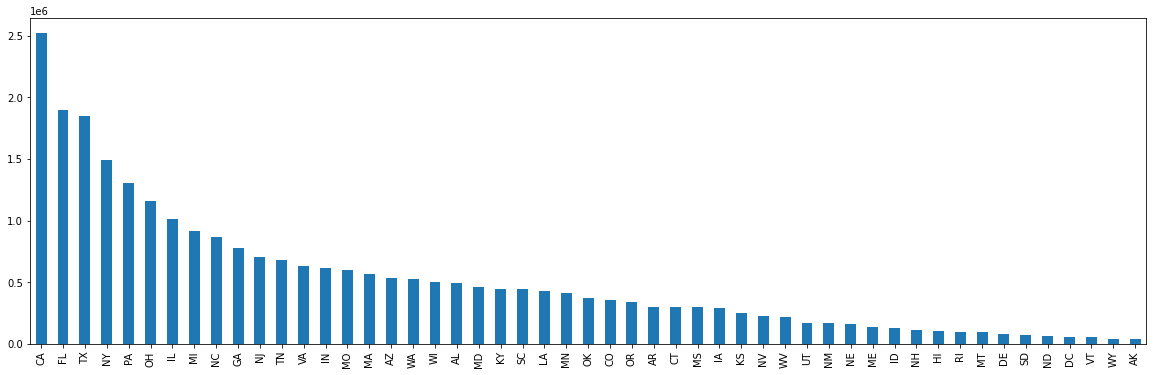

In [ ]:
original_data['Occurrence_State(FIPS)'].value_counts().plot(kind='bar',figsize=(20, 6))
print(original_data['Occurrence_State(FIPS)'].value_counts())

CA    47812
FL    38113
PA    33989
OH    32119
NY    27927
TX    26864
IL    20095
MI    19230
NJ    17127
NC    16535
MA    15295
TN    14622
MD    14530
AZ    13694
IN    12969
GA    12362
MO    12153
KY    12114
WA    10664
VA    10634
CO     9161
WI     9109
LA     8829
SC     7994
CT     7515
OK     7331
WV     7240
NV     6722
AL     6663
UT     5891
MN     5847
OR     5229
NM     5121
AR     3694
NH     3255
MS     3193
KS     3181
IA     2875
RI     2723
ME     2545
DE     2425
ID     2117
DC     1962
HI     1832
NE     1301
MT     1242
AK     1160
VT     1013
WY      848
SD      604
ND      523
Name: Occurrence_State(FIPS), dtype: int64


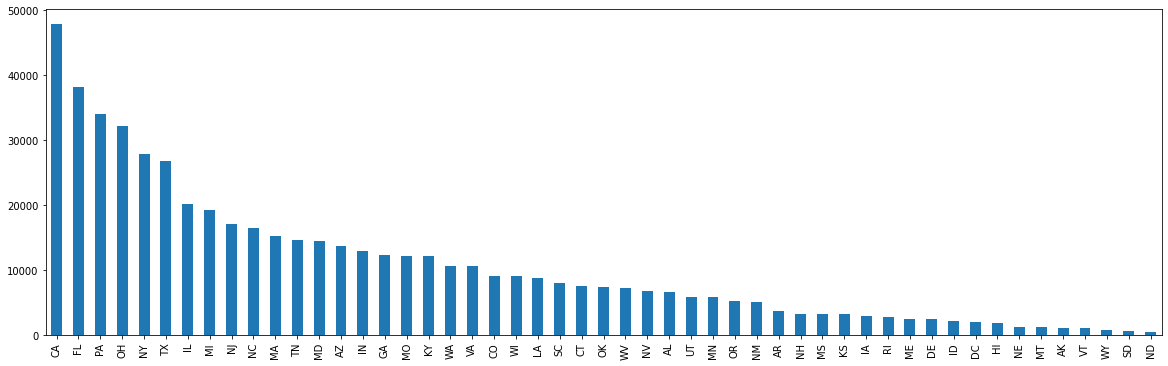

In [ ]:
original_overdose_data['Occurrence_State(FIPS)'].value_counts().plot(kind='bar',figsize=(20, 6))
print(original_overdose_data['Occurrence_State(FIPS)'].value_counts())

003    873721
037    829675
031    810491
013    715616
001    641113
        ...  
393        50
232        49
443        46
282        25
230        20
Name: Occurrence_County(FIPS), Length: 326, dtype: int64


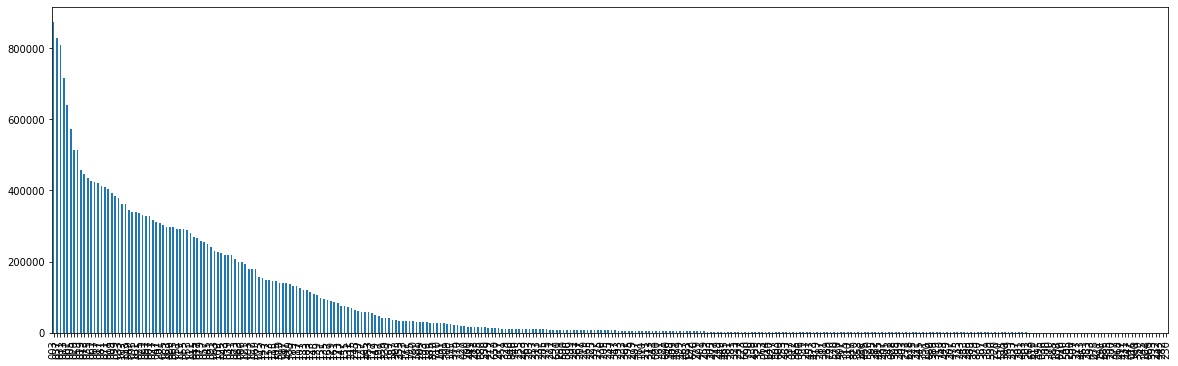

In [ ]:
original_data['Occurrence_County(FIPS)'].value_counts().plot(kind='bar',figsize=(20, 6))
print(original_data['Occurrence_County(FIPS)'].value_counts())

003    21112
031    18266
013    16542
001    13877
037    13830
       ...  
188        1
413        1
435        1
369        1
417        1
Name: Occurrence_County(FIPS), Length: 313, dtype: int64


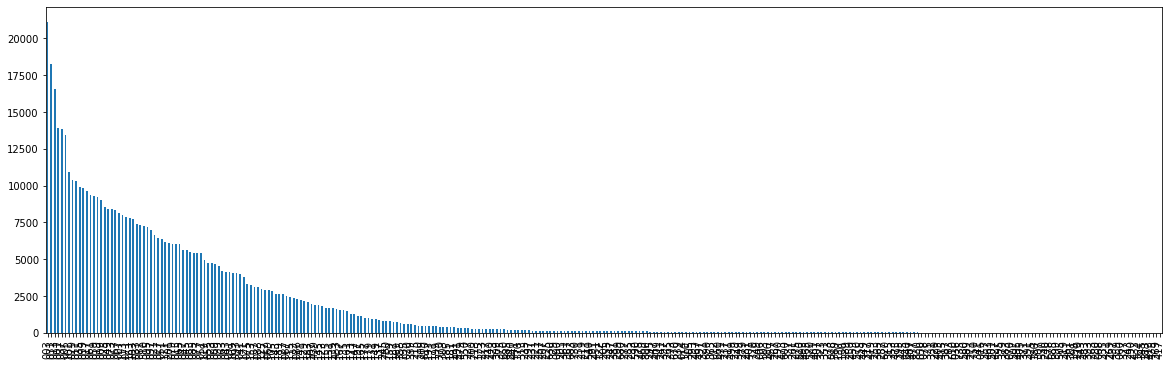

In [ ]:
original_overdose_data['Occurrence_County(FIPS)'].value_counts().plot(kind='bar',figsize=(20, 6))
print(original_overdose_data['Occurrence_County(FIPS)'].value_counts())

0    5824035
1    5388151
3    4636818
2    4213675
4    2706759
5    2011811
6    1198942
9     479668
Name: Occurrence_County_Population_size, dtype: int64


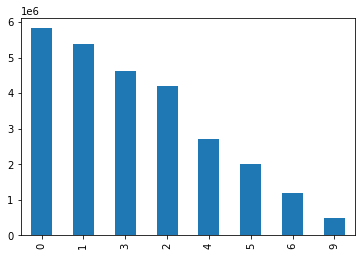

In [ ]:
original_data['Occurrence_County_Population_size'].value_counts().plot(kind='bar')
print(original_data['Occurrence_County_Population_size'].value_counts())

1    132249
0    126384
2     88420
3     87425
4     46683
5     32894
6     17377
9      6561
Name: Occurrence_County_Population_size, dtype: int64


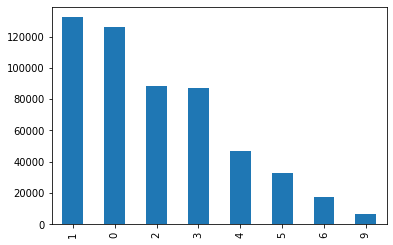

In [ ]:
original_overdose_data['Occurrence_County_Population_size'].value_counts().plot(kind='bar')
print(original_overdose_data['Occurrence_County_Population_size'].value_counts())

CA    2510152
FL    1879069
TX    1827562
NY    1507595
PA    1295796
OH    1156875
IL    1043146
MI     930933
NC     860716
GA     770701
NJ     718185
TN     650041
VA     640049
IN     611642
MO     583689
MA     556692
AZ     528303
WA     527548
AL     505973
WI     502848
MD     464467
SC     457891
KY     452349
LA     430219
MN     417207
OK     383198
CO     351568
OR     344260
AR     306884
MS     305448
CT     300105
IA     290723
KS     257956
NV     223020
WV     222826
NM     174621
UT     165683
NE     159824
ME     137791
ID     127987
NH     115670
HI     106080
RI      97677
MT      95283
DE      84012
SD      75045
ND      61567
VT      57029
ZZ      47801
DC      47335
WY      46373
AK      41002
PR       2244
VI        881
GU        208
AS         70
MP         23
XX         13
ON          3
QC          1
Name: Residence_State(FIPS), dtype: int64


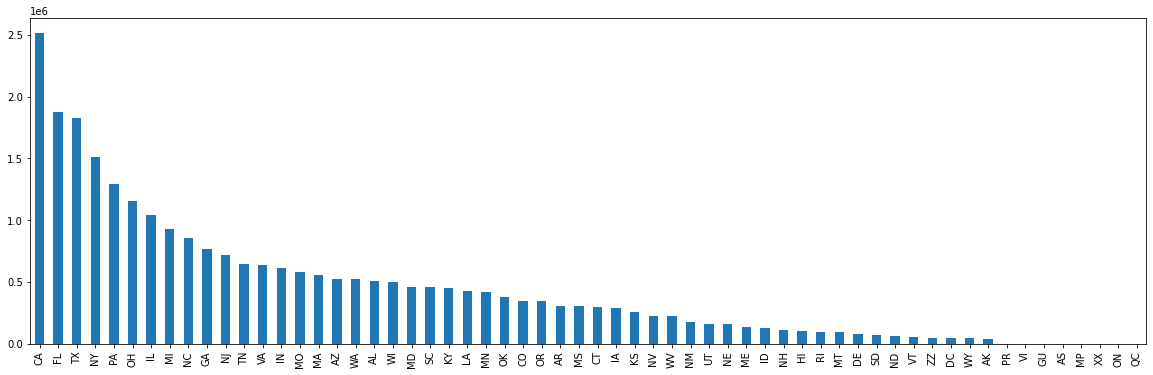

In [ ]:
original_data['Residence_State(FIPS)'].value_counts().plot(kind='bar',figsize=(20, 6))
print(original_data['Residence_State(FIPS)'].value_counts())

CA    46896
FL    36639
PA    33749
OH    31997
NY    27795
TX    26964
IL    20122
MI    19363
NJ    17533
NC    16704
MA    15385
TN    14500
MD    14386
AZ    13484
IN    13071
GA    12471
KY    12173
MO    11965
VA    10839
WA    10609
WI     9116
CO     8933
LA     8700
SC     8084
CT     7522
OK     7412
WV     7198
AL     6838
NV     6264
UT     5850
MN     5838
OR     5195
NM     5127
AR     3801
MS     3355
NH     3303
KS     3245
IA     2894
RI     2620
ME     2587
DE     2449
ZZ     2441
ID     2177
HI     1817
DC     1706
NE     1325
MT     1276
AK     1184
VT     1034
WY      881
SD      610
ND      481
PR       77
VI        6
GU        2
Name: Residence_State(FIPS), dtype: int64


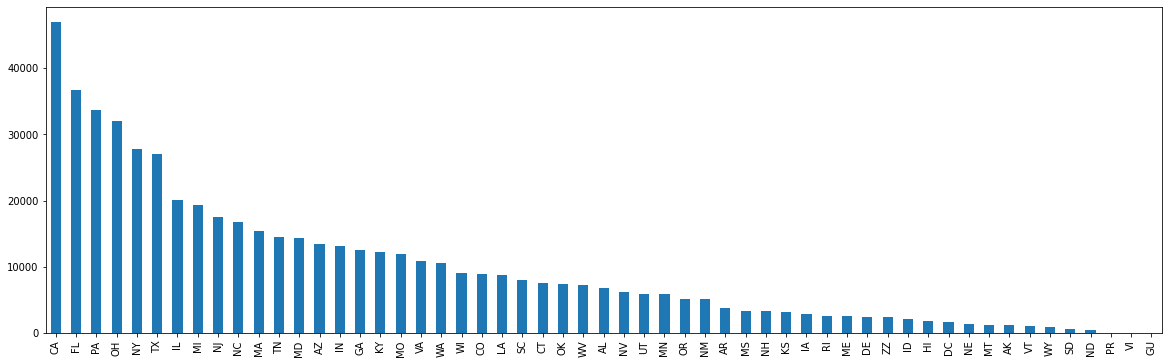

In [ ]:
original_overdose_data['Residence_State(FIPS)'].value_counts().plot(kind='bar',figsize=(20, 6))
print(original_overdose_data['Residence_State(FIPS)'].value_counts())

003    833759
037    813052
031    796801
013    690631
001    606286
        ...  
232        77
060        77
282        36
230        28
999         5
Name: Residence_County(FIPS), Length: 328, dtype: int64


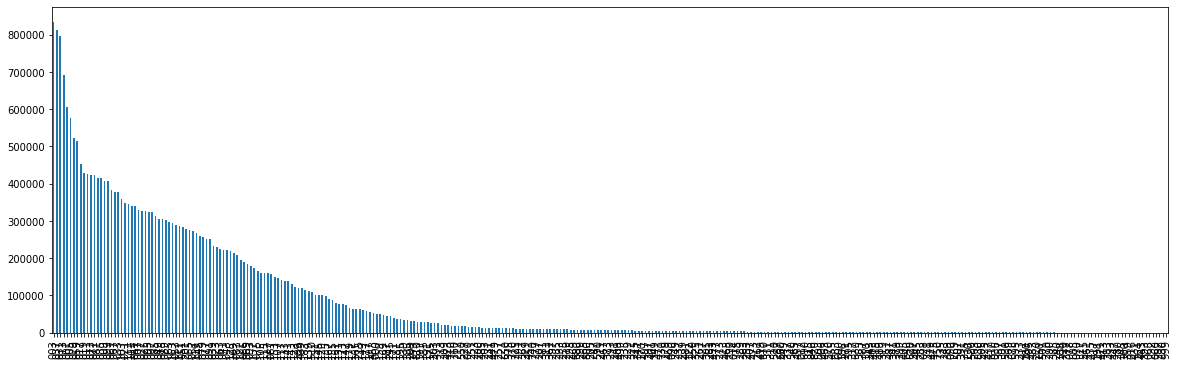

In [ ]:
original_data['Residence_County(FIPS)'].value_counts().plot(kind='bar',figsize=(20, 6))
print(original_data['Residence_County(FIPS)'].value_counts())

003    20482
031    17325
013    16260
005    14255
001    13353
       ...  
345        1
435        1
060        1
999        1
417        1
Name: Residence_County(FIPS), Length: 320, dtype: int64


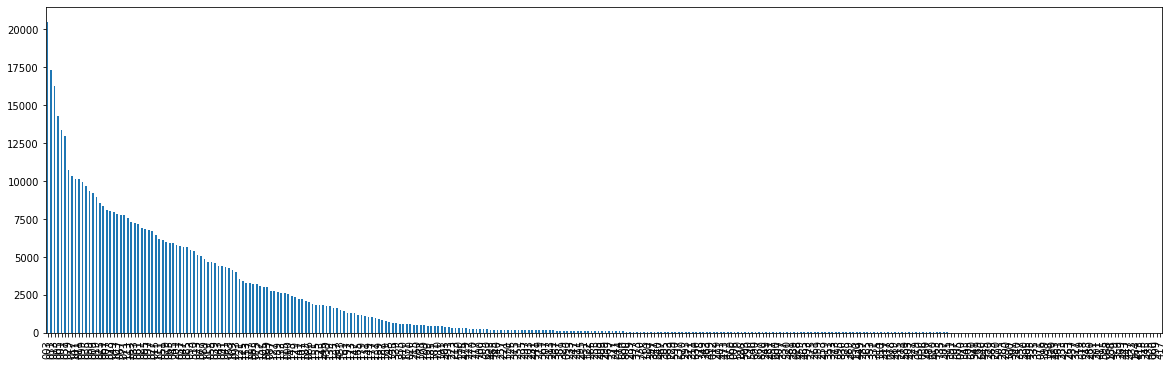

In [ ]:
original_overdose_data['Residence_County(FIPS)'].value_counts().plot(kind='bar',figsize=(20, 6))
print(original_overdose_data['Residence_County(FIPS)'].value_counts())

     16445815
1     7600964
2     2396428
Z       16652
Name: Residence_Met_or_Nonmet_county, dtype: int64


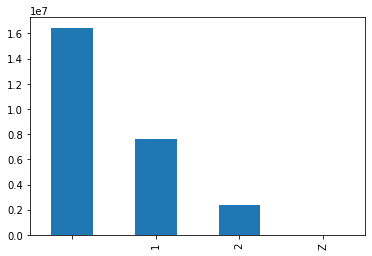

In [ ]:
original_data['Residence_Met_or_Nonmet_county'].value_counts().plot(kind='bar')
print(original_data['Residence_Met_or_Nonmet_county'].value_counts())

     372752
1    132394
2     32399
Z       448
Name: Residence_Met_or_Nonmet_county, dtype: int64


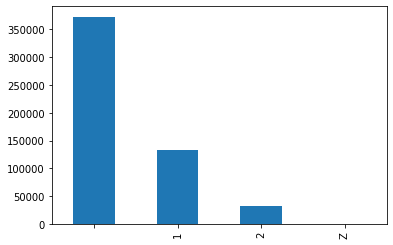

In [ ]:
original_overdose_data['Residence_Met_or_Nonmet_county'].value_counts().plot(kind='bar')
print(original_overdose_data['Residence_Met_or_Nonmet_county'].value_counts())

01    2483519
12    2379742
03    2347227
10    2192116
02    2191086
11    2189898
04    2178542
05    2168189
07    2109993
08    2100775
06    2060330
09    2058442
Name: The_Decedent_Date_of_Death, dtype: int64


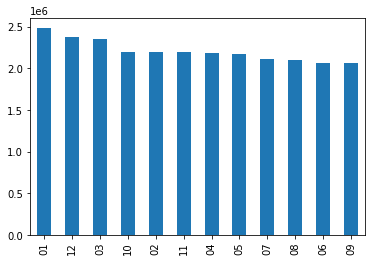

In [ ]:
original_data['The_Decedent_Date_of_Death'].value_counts().plot(kind='bar')
print(original_data['The_Decedent_Date_of_Death'].value_counts())

03    46608
07    46199
08    45777
12    45757
05    45261
10    44856
01    44640
06    44300
09    44004
04    43981
11    43927
02    42683
Name: The_Decedent_Date_of_Death, dtype: int64


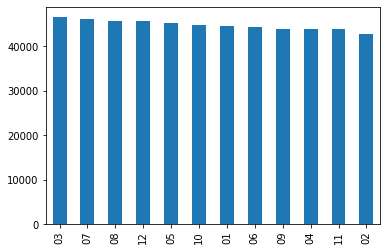

In [ ]:
original_overdose_data['The_Decedent_Date_of_Death'].value_counts().plot(kind='bar')
print(original_overdose_data['The_Decedent_Date_of_Death'].value_counts())

KeyboardInterrupt: ignored

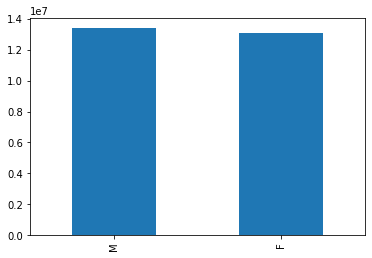

In [ ]:
original_data['The_Decedent_Sex'].value_counts().plot(kind='bar')
print(original_data['The_Decedent_Sex'].value_counts())

In [ ]:
original_overdose_data['The_Decedent_Sex'].value_counts().plot(kind='bar')
print(original_overdose_data['The_Decedent_Sex'].value_counts())

In [ ]:
original_data['The_Decedent_Age'].value_counts().plot(kind='bar',figsize=(50, 6))
print(original_data['The_Decedent_Age'].value_counts())

In [ ]:
original_overdose_data['The_Decedent_Age'].value_counts().plot(kind='bar',figsize=(50, 6))
print(original_overdose_data['The_Decedent_Age'].value_counts())

In [ ]:
original_data['The_Decedent_Marital_status'].value_counts().plot(kind='bar',figsize=(5, 6))
print(original_data['The_Decedent_Marital_status'].value_counts())

In [ ]:
original_overdose_data['The_Decedent_Marital_status'].value_counts().plot(kind='bar',figsize=(5, 6))
print(original_overdose_data['The_Decedent_Marital_status'].value_counts())

In [ ]:
original_data['The_Decedent_State_or_country_of_birth'].value_counts().plot(kind='bar',figsize=(50, 6))
print(original_data['The_Decedent_State_or_country_of_birth'].value_counts())

In [ ]:
original_overdose_data['The_Decedent_State_or_country_of_birth'].value_counts().plot(kind='bar',figsize=(50, 6))
print(original_overdose_data['The_Decedent_State_or_country_of_birth'].value_counts())

In [ ]:
original_data['The_Decedent_Education'].value_counts().plot(kind='bar',figsize=(5, 6))
print(original_data['The_Decedent_Education'].value_counts())

In [ ]:
original_overdose_data['The_Decedent_Education'].value_counts().plot(kind='bar',figsize=(5, 6))
print(original_overdose_data['The_Decedent_Education'].value_counts())

In [ ]:
#original_data['Underlying_Cause_ICD-10_code'].value_counts().plot(kind='bar',figsize=(5, 6))
print(original_data['Underlying_Cause_ICD-10_code'].value_counts())

In [ ]:
original_overdose_data['Underlying_Cause_ICD-10_code'].value_counts().plot(kind='bar',figsize=(5, 6))
print(original_overdose_data['Underlying_Cause_ICD-10_code'].value_counts())

In [ ]:
original_data['The_Decedent_Race'].value_counts().plot(kind='bar',figsize=(5, 6))
print(original_data['The_Decedent_Race'].value_counts())

In [ ]:
original_overdose_data['The_Decedent_Race'].value_counts().plot(kind='bar',figsize=(5, 6))
print(original_overdose_data['The_Decedent_Race'].value_counts())

# Neural Network1

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential([
    Dense(units=12, input_dim=19,activation='relu'),
    Dense(units=9, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                240       
                                                                 
 dense_4 (Dense)             (None, 9)                 117       
                                                                 
 dense_5 (Dense)             (None, 1)                 10        
                                                                 
Total params: 367
Trainable params: 367
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_x_hashed, y=train_y, epochs=100)

Epoch 1/100
23538/23538 [==============================] - 39s 2ms/step - loss: 0.1897 - accuracy: 0.9483
Epoch 2/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1881 - accuracy: 0.9490
Epoch 3/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1858 - accuracy: 0.9497
Epoch 4/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1820 - accuracy: 0.9505
Epoch 5/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1789 - accuracy: 0.9507
Epoch 6/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1770 - accuracy: 0.9507
Epoch 7/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1761 - accuracy: 0.9507
Epoch 8/100
23538/23538 [==============================] - 37s 2ms/step - loss: 0.1749 - accuracy: 0.9507
Epoch 9/100
23538/23538 [==============================] - 38s 2ms/step - loss: 0.1737 - accuracy: 0.9508
Epoch 10/100
23538/23538 [====================

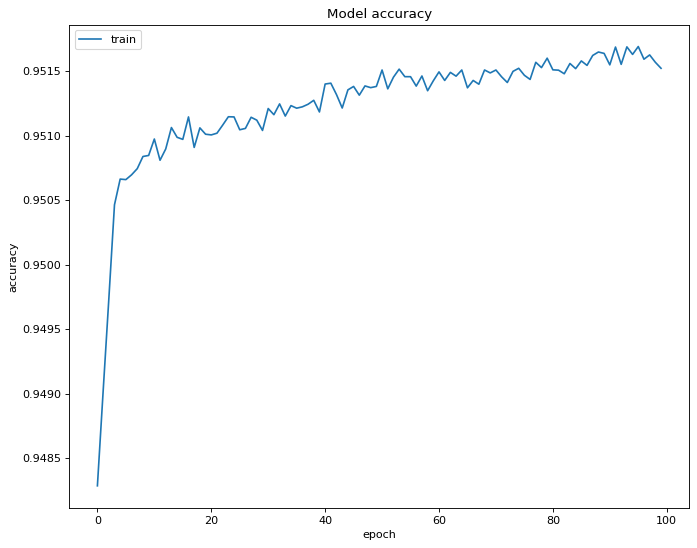

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

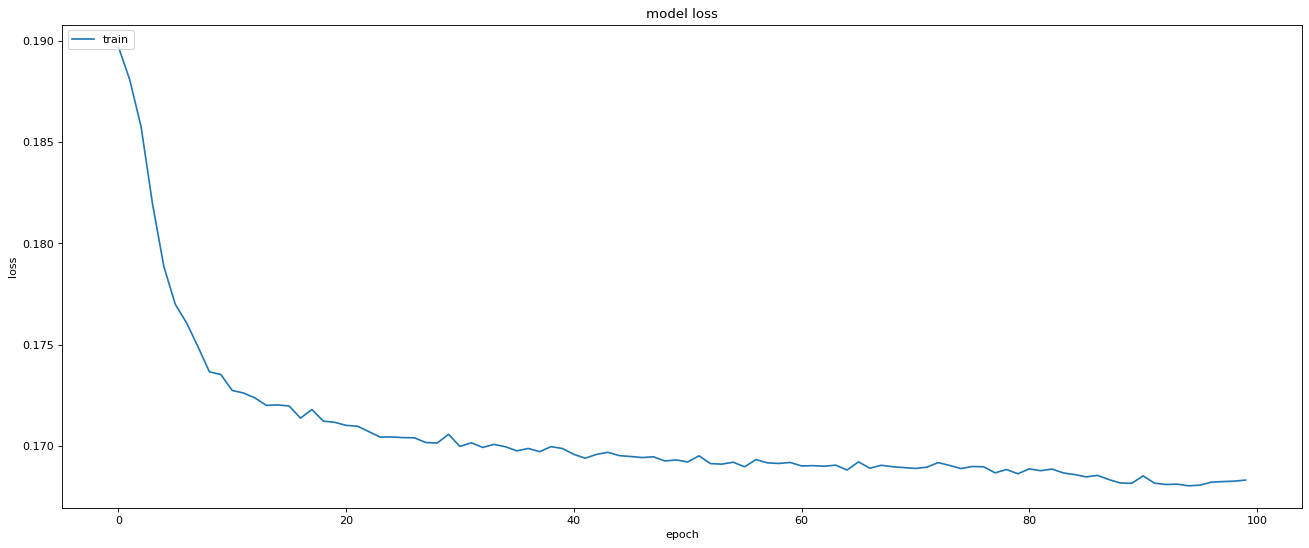

In [ ]:
# summarize history for loss
plt.figure(figsize=(20, 8), dpi=80)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

6725/6725 [==============================] - 7s 965us/step


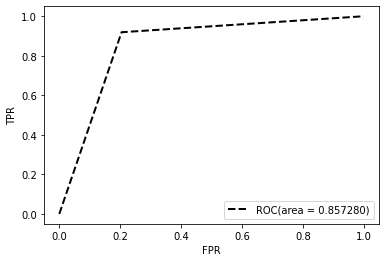

In [ ]:
y_pred = (model.predict(validation_x_hashed) > 0.5).astype("int32")

fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

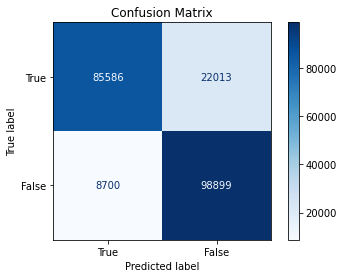

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay

color = 'black'
matrix = metrics.confusion_matrix(y_true=validation_y, y_pred=y_pred)  # shape=(12, 12)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['True', 'False'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', color=color)
plt.show()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(validation_y, y_pred, average='macro'))

print(recall_score(validation_y, y_pred, average='macro'))

0.8628347633345939
0.857280272121488


In [ ]:
acc = model.evaluate(x=validation_x_hashed, y=validation_y)

6725/6725 [==============================] - 8s 1ms/step - loss: 0.5077 - accuracy: 0.8573


# Correaltion Map

In [ ]:
original_data

,General_Record_Type,General_Resident_status,General_Place_of_death_and_decedents_status,General_Day_of_week_of_death,General_Data_year,General_Manner_of_death,Occurrence_State(FIPS),Occurrence_County(FIPS),Occurrence_County_Population_size,Residence_State(FIPS),...,The_Decedent_Date_of_Death,The_Decedent_Sex,The_Decedent_Age,The_Decedent_Marital_status,The_Decedent_State_or_country_of_birth,The_Decedent_Education,Underlying_Cause_ICD-10_code,The_Decedent_Race_Recode_5,The_Decedent_Hispanic_Origin/Race_Recode,The_Decedent_Race
0,2,2,6,6,2010,7,AK,020,2,AK,...,01,F,1068,D,AK AK,2,G049,3,8,3
1,1,1,4,1,2010,7,AK,170,4,AK,...,01,F,1012,S,AK AK,1,C37,1,6,1
2,1,1,4,1,2010,7,AK,170,4,AK,...,01,F,1075,D,OR OR,2,C719,1,6,1
3,1,1,4,6,2010,7,AK,020,2,AK,...,01,M,1061,W,ZZ YY,2,F03,4,8,4
4,1,1,4,7,2010,2,AK,170,4,AK,...,01,F,1046,M,CT CT,4,X72,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26459854,1,1,1,7,2019,7,NY,005,0,NY,...,05,M,1049,U,ZZ ZZ,9,K590,1,9,1
26459855,1,1,4,2,2019,7,NY,005,0,NY,...,10,M,1066,S,ZZ ZZ,9,C61,1,9,1
26459856,2,2,1,2,2019,7,NY,005,0,NY,...,12,M,1050,M,ZZ YY,8,D761,2,7,2
26459857,1,1,4,1,2019,7,NY,005,0,NY,...,12,F,1082,W,ZZ YY,3,E854,2,7,2


In [ ]:
original_data.corr()

""


In [ ]:

correlation_matrix = original_data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()


ValueError: ignored

<Figure size 864x648 with 0 Axes>